Loading data and computing target diagram statistics...

PR:
  historical... Done
  ssp126... Done
  ssp245... Done
  ssp585... Done

TAS:
  historical... Done
  ssp126... Done
  ssp245... Done
  ssp585... Done

HURS:
  historical... Done
  ssp126... Done
  ssp245... Done
  ssp585... Done

SFCWIND:
  historical... Done
  ssp126... Done
  ssp245... Done
  ssp585... Done

All statistics computed!

Creating target diagram...


/tmp/ipykernel_155426/3077462281.py:315: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.90, 1.0])


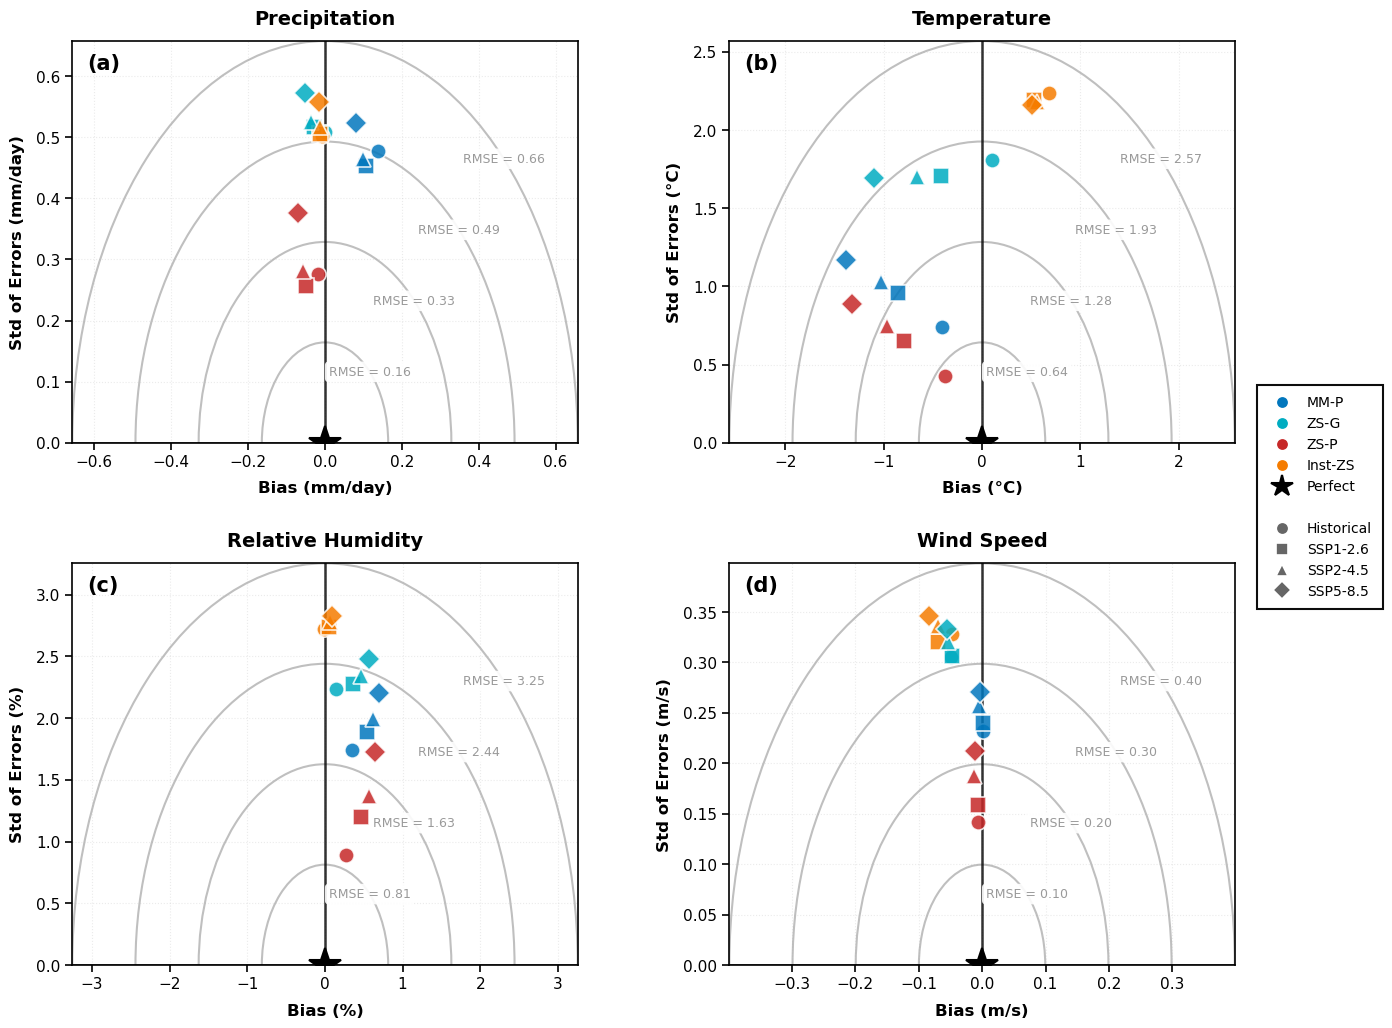

In [2]:
# analyze_target_diagram.py

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
import matplotlib.lines as mlines
from matplotlib.patches import Circle

# ----------------------------
# Configuration
# ----------------------------
results_dir = Path("evaluation_results")
variables = ['pr', 'tas', 'hurs', 'sfcWind']
scenarios = ['historical', 'ssp126', 'ssp245', 'ssp585']

# ONLY 4 normalization methods to compare
normalizations = ['minmax_pixel', 'zscore_global', 'zscore_pixel', 'instance_zscore']

# Variable configuration
var_config = {
    'pr': {'label': 'Precipitation', 'unit': 'mm/day'},
    'tas': {'label': 'Temperature', 'unit': '°C'},
    'hurs': {'label': 'Relative Humidity', 'unit': '%'},
    'sfcWind': {'label': 'Wind Speed', 'unit': 'm/s'}
}

# Normalization labels
norm_labels = {
    'minmax_pixel': 'MM-P',
    'zscore_global': 'ZS-G',
    'zscore_pixel': 'ZS-P',
    'instance_zscore': 'Inst-ZS'
}

# Scenario labels
scenario_labels = {
    'historical': 'Historical',
    'ssp126': 'SSP1-2.6',
    'ssp245': 'SSP2-4.5',
    'ssp585': 'SSP5-8.5'
}

# Colors for normalization methods
norm_colors = {
    'minmax_pixel': '#0277BD',   # Dark Blue
    'zscore_global': '#00ACC1',  # Cyan
    'zscore_pixel': '#C62828',   # Dark Red
    'instance_zscore': '#F57C00' # Dark Orange
}

# Marker styles for each scenario
scenario_markers = {
    'historical': 'o',  # circle
    'ssp126': 's',      # square
    'ssp245': '^',      # triangle up
    'ssp585': 'D'       # diamond
}

# ----------------------------
# Functions
# ----------------------------
def calculate_bias_std_from_temporal_mean(pred_data, gt_data):
    """
    Calculate bias and standard deviation for target diagram using temporal mean spatial maps.
    
    Process:
    1. Average over time to get 2D spatial maps: (time, lat, lon) -> (lat, lon)
    2. Flatten to 1D: (lat, lon) -> (lat*lon,)
    3. Calculate statistics
    
    Parameters:
    - pred_data: 3D array (time, lat, lon) or xarray DataArray
    - gt_data: 3D array (time, lat, lon) or xarray DataArray
    
    Returns:
    - bias: mean bias (prediction - ground truth)
    - std_error: standard deviation of errors (random error component)
    - rmse: total RMSE
    
    Note: RMSE² = Bias² + StdError²
    """
    # Calculate temporal mean to get 2D spatial maps
    if isinstance(pred_data, xr.DataArray):
        pred_mean_2d = pred_data.mean(dim='time').values  # Shape: (lat, lon)
        gt_mean_2d = gt_data.mean(dim='time').values      # Shape: (lat, lon)
    else:
        pred_mean_2d = np.mean(pred_data, axis=0)  # Shape: (lat, lon)
        gt_mean_2d = np.mean(gt_data, axis=0)      # Shape: (lat, lon)
    
    # Flatten spatial dimensions to 1D
    pred_flat = pred_mean_2d.flatten()
    gt_flat = gt_mean_2d.flatten()
    
    # Remove NaN values
    mask = ~(np.isnan(pred_flat) | np.isnan(gt_flat))
    pred_flat = pred_flat[mask]
    gt_flat = gt_flat[mask]
    
    # Calculate errors
    errors = pred_flat - gt_flat
    
    # Bias (systematic error)
    bias = np.mean(errors)
    
    # Standard deviation of errors (random error component)
    std_error = np.std(errors)
    
    # Total RMSE
    rmse = np.sqrt(np.mean(errors**2))
    
    # Verify: RMSE² = Bias² + StdError²
    rmse_check = np.sqrt(bias**2 + std_error**2)
    assert np.isclose(rmse, rmse_check, rtol=1e-5), \
        f"RMSE decomposition failed: {rmse} vs {rmse_check}"
    
    return bias, std_error, rmse

# ----------------------------
# Load data and compute statistics
# ----------------------------
print("Loading data and computing target diagram statistics...")
print("="*80)

# Storage: stats[variable][scenario][normalization] = {bias, std_error, rmse}
stats = {var: {scen: {} for scen in scenarios} for var in variables}

for var in variables:
    print(f"\n{var.upper()}:")
    
    for scenario in scenarios:
        print(f"  {scenario}...", end=" ")
        
        # Load evaluation results
        results_file = results_dir / f"{var}_evaluation_{scenario}.nc"
        ds = xr.open_dataset(results_file)
        
        # Get ground truth (3D: time, lat, lon)
        gt_data = ds['groundtruth']
        
        # Compute statistics for each normalization
        for norm in normalizations:
            pred_key = f'pred_{norm}'
            
            if pred_key not in ds:
                continue
            
            pred_data = ds[pred_key]
            
            # Calculate target diagram statistics
            bias, std_error, rmse = calculate_bias_std_from_temporal_mean(pred_data, gt_data)
            
            stats[var][scenario][norm] = {
                'bias': bias,
                'std_error': std_error,
                'rmse': rmse
            }
        
        print("Done")

print("\n" + "="*80)
print("All statistics computed!")

# ----------------------------
# Create target diagram
# ----------------------------
print("\nCreating target diagram...")

# Set plotting style
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['xtick.major.width'] = 1.2
plt.rcParams['ytick.major.width'] = 1.2

# Create 2x2 subplot figure
fig = plt.figure(figsize=(15, 12))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# Panel labels
panel_labels = ['(a)', '(b)', '(c)', '(d)']

# Plot each variable
for idx, var in enumerate(variables):
    ax = fig.add_subplot(gs[idx // 2, idx % 2])
    
    # Find max values for axis limits
    max_bias = 0
    max_std = 0
    
    for scenario in scenarios:
        for norm in normalizations:
            if norm in stats[var][scenario]:
                max_bias = max(max_bias, abs(stats[var][scenario][norm]['bias']))
                max_std = max(max_std, stats[var][scenario][norm]['std_error'])
    
    # Add padding
    axis_limit = max(max_bias, max_std) * 1.15
    
    # Draw RMSE circles - MORE SOLID
    rmse_levels = np.linspace(0, axis_limit, 5)[1:]  # 4 circles
    
    for rmse_level in rmse_levels:
        circle = Circle((0, 0), rmse_level, fill=False,
                       edgecolor='gray', linestyle='-',  # Solid line instead of dashed
                       linewidth=1.5, alpha=0.5)  # Thicker and more visible
        ax.add_patch(circle)
        
        # Label circles with "RMSE = "
        ax.text(rmse_level * 0.707, rmse_level * 0.707,
               f'RMSE = {rmse_level:.2f}',  # Added "RMSE = " prefix
               fontsize=9, color='gray', alpha=0.8,
               ha='center', va='center',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white',
                        edgecolor='none', alpha=0.9))
    
    # Draw axes
    ax.axhline(y=0, color='black', linewidth=1.8, alpha=0.8, zorder=2)
    ax.axvline(x=0, color='black', linewidth=1.8, alpha=0.8, zorder=2)
    
    # Draw grid
    ax.grid(True, alpha=0.25, linestyle=':', linewidth=0.8, zorder=1)
    
    # Plot reference point (perfect model at origin)
    ax.plot(0, 0, 'k*', markersize=24,
           markeredgecolor='black', markeredgewidth=1.5, zorder=100)
    
    # Plot all model points
    for scenario in scenarios:
        for norm in normalizations:
            if norm in stats[var][scenario]:
                bias = stats[var][scenario][norm]['bias']
                std_error = stats[var][scenario][norm]['std_error']
                
                ax.plot(bias, std_error,
                       marker=scenario_markers[scenario],
                       color=norm_colors[norm],
                       markersize=11,
                       markeredgecolor='white',
                       markeredgewidth=1.2,
                       alpha=0.85,
                       linestyle='none',
                       zorder=50)
    
    # Set limits
    ax.set_xlim(-axis_limit, axis_limit)
    ax.set_ylim(0, axis_limit)
    
    # Labels
    ax.set_xlabel(f'Bias ({var_config[var]["unit"]})', 
                 fontsize=12, fontweight='bold', labelpad=8)
    ax.set_ylabel(f'Std of Errors ({var_config[var]["unit"]})', 
                 fontsize=12, fontweight='bold', labelpad=8)
    ax.set_title(var_config[var]['label'], 
                fontsize=14, fontweight='bold', pad=12)
    
    # Add panel label
    ax.text(0.03, 0.97, panel_labels[idx], transform=ax.transAxes,
           fontsize=15, fontweight='bold', va='top', ha='left')
    
    # Improve tick formatting
    ax.tick_params(labelsize=11, length=5, width=1.2)
    
    # Make spines more visible
    for spine in ax.spines.values():
        spine.set_linewidth(1.2)
        spine.set_edgecolor('black')

# ----------------------------
# Create merged legend
# ----------------------------
all_handles = []
all_labels = []

# Add normalization methods (only 4 now)
for norm in normalizations:
    handle = mlines.Line2D([], [], color=norm_colors[norm],
                          marker='o', linestyle='None',
                          markersize=9,
                          markeredgecolor='white', markeredgewidth=1.2)
    all_handles.append(handle)
    all_labels.append(norm_labels[norm])

# Add reference point
ref_handle = mlines.Line2D([], [], color='black', marker='*',
                          linestyle='None', markersize=16,
                          markeredgecolor='black', markeredgewidth=1.5)
all_handles.append(ref_handle)
all_labels.append('Perfect')

# Add spacing
all_handles.append(mlines.Line2D([], [], linestyle='None', marker='', markersize=0))
all_labels.append('')

# Add scenarios
for scenario in scenarios:
    handle = mlines.Line2D([], [], color='#666666',
                          marker=scenario_markers[scenario],
                          linestyle='None',
                          markersize=9,
                          markeredgecolor='white', markeredgewidth=1.2)
    all_handles.append(handle)
    all_labels.append(scenario_labels[scenario])

# Position legend
legend = fig.legend(handles=all_handles, labels=all_labels,
                   loc='center left', bbox_to_anchor=(0.91, 0.5),
                   fontsize=10, frameon=True, fancybox=False,
                   edgecolor='black', framealpha=0.95,
                   borderpad=0.8, labelspacing=0.5)
legend.get_frame().set_linewidth(1.5)

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.90, 1.0])
